In [1]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu,SmoothingFunction
import pandas as pd
import numpy as np
import docker
import os
import re
import random
from string import punctuation
import json
import matplotlib.pyplot as plt
punc = punctuation
smooth = SmoothingFunction()

In [2]:
def mythril_get(bb):
    mythril_result = []
    myt = bb['mythril']
    line = bb['contract_line']
    for index,j in enumerate(myt):
        if j != None and type(j) != float and len(j) > 0:
            total = []
            for i in j:
                #print(i)
                ccode = i.get('code')
                formatted = {
                    #'address':i['address'],
                    #'code':ccode,
                    'function':i['function'],
                    'lineno':i['lineno'],
                    'title':i['title'],
                    'type':i['type']
                }
                
                if(line[index][0] <= formatted['lineno'] and line[index][1] >= formatted['lineno']):
                    total.append(formatted)
            mythril_result.append(total)
        else:
            mythril_result.append([])
    return mythril_result
def slither_get(bb):
    slither_result = []
    sli = bb['slither']
    line = bb['contract_line']
    for index,j in enumerate(sli):
        if j != None and type(j) != float and len(j) > 0:
            temp=[]
            for i in j:
                if len(i['elements']) > 0 and i['elements'][0].get('source_mapping'):
                    func = i['elements'][0].get('name')
                    t = {
                        'title':i['check'],
                        'function':func,
                        #'contract':i['elements'][0].get('contract').get('name'),
                        'lineno':i['elements'][0]['source_mapping']['lines'],
                        'type':i['impact']
                    }
                    #print("t:"+str(t['lineno'][0]))
                    #print('line'+str(line[index][0])+str(line[index][1]))
                    if(len(t['lineno']) > 0 and line[index][0] <= t['lineno'][0] and line[index][1] >= t['lineno'][0]):
                        temp.append(t)
            slither_result.append(temp)
        else:
            slither_result.append([])
    return slither_result
def osiris_get(bb):
    result = []
    osi = bb['osiris']
    line = bb['contract_line']
    count = 0
    for  index,i in enumerate(osi):
        if i != None and type(i) != float and len(i) > 0:
            temp = []  
            for j in i:
                error = j['errors']
                name = j['name']
                if len(error) > 0:
                    for ttt in error:
                        t = {
                            'title':ttt['message'],
                            'lineno':ttt['line'],
                            'function':name
                        }
                        if(line[index][0] <= t['lineno'] and line[index][1] >= t['lineno']):
                            temp.append(t)
            result.append(temp)
        else:
            result.append([])
    return result
def find_range(code,f):
    head = code.splitlines()[0]
    hang = f.splitlines()
    for i in range(len(hang)):
        if head in hang[i]:
            a = i
            flag = 1
            j = i+1
            while flag != 0 and j < len(hang):
                if '{' in hang[j]:
                    flag += hang[j].count('{')
                if '}' in hang[j]:
                    flag -= hang[j].count('}')
                j += 1
            return [a,j-1]
    return [0,0]
def find_func_range(code,f):
    head = code.splitlines()[0]
    hang = f.splitlines()
    for i in range(len(hang)):
        if head in hang[i]:
            a = i
            flag = 1
            j = i+1
            while flag != 0 and j < len(hang):
                if '{' in hang[j]:
                    flag += hang[j].count('{')
                if '}' in hang[j]:
                    flag -= hang[j].count('}')
                j += 1
            return [a,j-1]
    print("find_func_range error")
    return [0,0]
def get_contract_line(bb):
    code_range = []
    name = list(bb['code_name'])
    for i in range(len(name)):
        try:
            f = open('/home/yfliu/data_sol/'+name[i],encoding = 'utf-8').read()
        except:
            f = open('/home/yfliu/data_sol/'+name[i],encoding = 'GBK').read()
        code = bb.loc[i,'contract_code']
        con_range = find_range(code,f)
        code_range.append(con_range)
    return code_range
def get_function_line(bb):
    code_range = []
    name = list(bb['code_name'])
    for i in range(len(name)):
        try:
            f = open('/home/yfliu/data_sol/'+name[i],encoding = 'utf-8').read()
        except:
            f = open('/home/yfliu/data_sol/'+name[i],encoding = 'GBK').read()
        code = bb.loc[i,'contract_code']
        con_range = find_func_range(code,f)
        code_range.append(con_range)
    return code_range
def add_sol(sol_name,target):
    temp = target[sol_name]
    #print(temp[0])
    for i in range(len(temp)):
        if '.sol' not in temp[i]:
            temp[i] += '.sol'
    target[sol_name] = temp
def check_len(x):
    return len(x)
def print_code(addr):
    ttt = open("/home/yfliu/data_sol/"+addr).read().splitlines()
    for index,i in enumerate(ttt):
        print(str(index)+i)
def func_code(coindex):
    ana = bb[bb['code_index'] == coindex].iloc[0]
    #print(ana['contract_code'])
    for j in ['osiris_analysis','mythril_analysis_not_info','slither_analysis_not_info']:
        print(j)
        for i in ana[j]:
            print(i)
        print()
    def spli(x):
        return x.split('-')[0]
    def include_f(x,y):
        return y in eval(x)['href']
    temp2 = bb[bb['code_index'] == coindex]['sni_name'].apply(spli)
    print(list(temp2))
    for i in temp2:
        temp = post[post['info'].apply(include_f,y = i)]
        print(eval(temp.iloc[0]['info'])['href'])
    print_code(ana['code_name'])
    
    
head = [' access_control ',
 ' arithmetic ',
 ' denial_service ',
 ' reentrancy ',
 ' unchecked_low_calls ',
 ' bad_randomness ',
 ' front_running ',
 ' time_manipulation ',
 ' short_addresses ',
 ' Other ',
 ' Ignore ']
dic = dict(zip(head,[0]*10))
mapping = open('/home/yfliu/mapping.json').read()
mapp = json.loads(mapping)
#重要程度
slither_map = mapp['slither']
slither_key = slither_map.keys()
slither_type_map = dict(zip(slither_key,[0]*len(slither_key)))
u = open('/home/yfliu/paper/trash/temp.txt').read()
for i in u.splitlines():
    sp = i.split()
    slither_type_map[sp[1]] = sp[-2]
slither_type_map
slither_type_map['constant-function'] = 'Medium'
slither_bug_patch = ['constable-states','erc20-indexed','erc20-interface','external-function','incorrect-equality','naming-convention','shadowing-local','shadowing-state','shadowing-builtin','shadowing-abstract']    

In [4]:
bugRes = pd.read_pickle('/home/yfliu/paper_data/completeRes/manualBugRes.pic')
#bugRes = pd.read_csv('/home/yfliu/paper_data/BugRes_bleu.csv')
bugRes

,name,mythril,osiris,slither
0,0x9DA53246714bf10010Aee31ffDb9cf8caB8c6813,"[{""address"": 4897, ""code"": ""}\n\n "", ""debug"":...","[{""errors"": [], ""file"": ""/data/0x9DA53246714bf...","[{""check"": ""shadowing-builtin"", ""impact"": ""Low..."
1,0x083af4bc701cdd3b5e42cabdceb823813bc75e52,[],[],"[{""check"": ""locked-ether"", ""impact"": ""Medium"",..."
2,0xea4c5b7088823f6851198ae908a59ee1d6a9c8c9,"[{""address"": 3680, ""code"": ""\n "", ""debug"": ...","[{""errors"": [], ""file"": ""//home/yfliu/data_sol...","[{""check"": ""shadowing-local"", ""impact"": ""Low"",..."
3,0x0dD1C99aC9BC48A1d482878ECC8B9760Aa1e8De2,"[{""address"": 213, ""code"": ""tingFinished);\n\n ...","[{""errors"": [], ""file"": ""//home/yfliu/data_sol...","[{""check"": ""suicidal"", ""impact"": ""High"", ""conf..."
4,0x13c2fab6354d3790d8ece4f0f1a3280b4a25ad96,[],"[{""errors"": [], ""file"": ""//home/yfliu/data_sol...","[{""check"": ""assembly"", ""impact"": ""Informationa..."
...,...,...,...,...
533,0x5caa790ee0586c78db45da6e37409315d1712f3e,[],"[{""errors"": [{""line"": 106, ""column"": 9, ""messa...","[{""check"": ""uninitialized-state"", ""impact"": ""H..."
534,0x372ce28440082152af33980eb1ac5e129221a876,[],"[{""errors"": [{""line"": 52, ""column"": 13, ""messa...","[{""check"": ""constable-states"", ""impact"": ""Info..."
535,0x620aa38177b61c08390b63f9850cddf221399063,"[{""address"": 1210, ""debug"": """", ""description"":...","[{""errors"": [], ""file"": ""//home/yfliu/replaceS...","[{""check"": ""unused-return"", ""impact"": ""Medium""..."
536,0xeaac86b9f0743ed4ca7fd07601b63218f1612b0f,None,[],[]


In [6]:
matchPath = "/home/yfliu/paper_data/manualResultCsv/manualCon.csv"
match = pd.read_csv(matchPath)
match

,sni,bleu,code,check,sni_index,code_index
0,contract Test { uint256 public value; function...,0.757180,contract Test {\n uint public test;\n \n...,1.0,45,61793
1,contract Message {\n string myMessage;\n\n ...,0.711363,contract MyTest{\n string private name;\n ...,1.0,61,63568
2,contract Project {\n bytes32 public value;\...,0.707395,contract Example {\n\n uint256 public value...,1.0,65,12047
3,contract NewContract {\n constructor() public...,0.746086,contract BlankContract {\n constructor() pu...,1.0,94,25053
4,contract interfaceB {\n function protectedFun...,0.709232,contract ZethrInterface{\n function withdra...,1.0,97,3273
...,...,...,...,...,...,...
645,contract ERC223Interface {\n uint public to...,0.955526,contract ERC223Interface {\n\n function bal...,0.0,6865,23241
646,"contract Token {\n function mint(address _to,...",0.912484,contract Token {\n function transfer(addres...,1.0,6868,42026
647,contract SimpleToken is ERC20 {\n\n string pu...,0.917062,contract BitQueen is ERC20 {\n\n string publi...,1.0,7049,2076
648,contract ERC223Receiver\n{\n function token...,0.914567,contract ContractReceiver {\n function toke...,1.0,7093,2508


In [7]:
matchPath = "/home/yfliu/paper_data/matchRes/match_function.csv"
match = pd.read_csv(matchPath)

match['snippet'] = match.index
match['code'] = match['0']
match = match[match['code'].apply(lambda x : len(eval(x)) > 0 )]
match

,0,snippet,code
4,"[3025, 3076, 3109, 3536, 5844, 5969, 6909, 713...",4,"[3025, 3076, 3109, 3536, 5844, 5969, 6909, 713..."
13,[32568],13,[32568]
21,"[10964, 45098, 103724]",21,"[10964, 45098, 103724]"
23,"[85, 2694, 4466, 5035, 11466, 11734, 12257, 22...",23,"[85, 2694, 4466, 5035, 11466, 11734, 12257, 22..."
37,[50596],37,[50596]
...,...,...,...
6233,"[229, 4699, 4806, 40276, 45269, 47430, 65822, ...",6233,"[229, 4699, 4806, 40276, 45269, 47430, 65822, ..."
6272,"[229, 4699, 4806, 40276, 45269, 47430, 65822, ...",6272,"[229, 4699, 4806, 40276, 45269, 47430, 65822, ..."
6280,"[229, 4699, 4806, 40276, 45269, 47430, 65822, ...",6280,"[229, 4699, 4806, 40276, 45269, 47430, 65822, ..."
6316,"[447, 738, 986, 5584, 6655, 8374, 8425, 9050, ...",6316,"[447, 738, 986, 5584, 6655, 8374, 8425, 9050, ..."


In [67]:
#fun
sniPath = "/home/yfliu/paper_data/conFunFormat/snippet_function.csv"
codePath = "/home/yfliu/paper_data/conFunFormat/code_function.csv"
matchPath = "/home/yfliu/paper_data/matchRes/match_function.csv"
#matchPath = "/home/yfliu/paper_data/function_bleu_ast_all.csv"

#replace
#con
if run == 'con':
    sniPath = "/home/yfliu/paper_data/conFunFormat/snippet_contract.csv"
    codePath = "/home/yfliu/paper_data/conFunFormat/code_contract.csv"
    matchPath = "/home/yfliu/paper_data/matchRes/match_contract.csv"#ast方法下，修改match
    #matchPath = "/home/yfliu/paper_data/contract_bleu_ast_all.csv"
#matchPath = "/home/yfliu/paper_data/matchRes/match_contract.csv"

snippet = pd.read_csv(sniPath)
code = pd.read_csv(codePath)
match = pd.read_csv(matchPath)

match['snippet'] = match.index
match['code'] = match['0']
match = match[match['code'].apply(lambda x : len(eval(x)) > 0 )]
#len(set(match['code'].apply(lambda x : eval(x)[0])))

#获得bb
sni_index = 'snippet'
code_index = 'code'
sni_index = ''
snippet = snippet[['sol_name','code']]
code_name = []
contract_code = []
sni_name = []
sni_code = []
dealed_code = []
for index,i in match.iterrows():
    a = snippet.loc[int(i['snippet'])]
    b = code.loc[eval(i['code'])[0]]#AST
    code_name.append(b['code_name'])
    contract_code.append(b['code'])
    dealed_code.append(b['dealed_code'])
    sni_name.append(a['sol_name'])
    sni_code.append(a['code'])
bb = pd.DataFrame({
    'sni_index':list(match['snippet']),
    'code_index':[int(eval(item)[0]) for item in list(match['code'])],#ast
    'code_name':code_name,
    'dealed_code':dealed_code,
    'sni_name':sni_name,
    'contract_code':contract_code,
    'sni_code':sni_code
})
#为结果添加.sol方便下一步处理 确定contract在完整合约的范围 把工具结果(未处理)贴上去
bname = bb['code_name']
bb['contract_line'] = get_contract_line(bb)
bb

bb['name'] = bb['code_name'].apply(lambda x : x.split('.')[0])
bb = bb.merge(bugRes,on='name')
bb['mythril'] = bb['mythril'].apply(lambda x : json.loads(x) if type(x) != float else None)
bb['slither'] = bb['slither'].apply(lambda x : json.loads(x) if type(x) != float else None)
bb['osiris'] = bb['osiris'].apply(lambda x : json.loads(x) if type(x) != float else None)
bb['osiris_analysis'] = osiris_get(bb)
bb['mythril_analysis'] = mythril_get(bb)
bb['slither_analysis'] = slither_get(bb)

slither_temp = list(bb['slither_analysis'])
slither_info = []
for item in slither_temp:
    del_list = []
    info_list = []
    for index,t_item in enumerate(item):
        title = t_item['title']
        level = slither_type_map[title]
        if level == 'Informational' or title in slither_bug_patch:
            del_list.append(index)
    del_list.reverse()
    for tempt in del_list:
        info_list.append(item[tempt])
        del item[tempt]
    slither_info.append(info_list)
bb['slither_analysis_not_info'] = slither_temp
#bb['slither_analysis_info'] = slither_info
slither_temp = list(bb['mythril_analysis'])
slither_info = []
for item in slither_temp:
    del_list = []
    info_list = []
    for index,t_item in enumerate(item):
        #title = t_item['title']
        level = t_item['type']
        if level != 'Warning':
            del_list.append(index)
    del_list.reverse()
    for tempt in del_list:
        info_list.append(item[tempt])
        del item[tempt]
    slither_info.append(info_list)
bb['mythril_analysis_not_info'] = slither_temp
bb

,sni_index,code_index,code_name,dealed_code,sni_name,contract_code,sni_code,contract_line,name,mythril,osiris,slither,osiris_analysis,mythril_analysis,slither_analysis,slither_analysis_not_info,mythril_analysis_not_info
0,2,46,0xcf2b19384ea3f027f8620db3f797ae61bb475125.sol,"['contract', 'multisig', 'event', 'Depositaddr...",7089-1.sol,contract multisig {\n\n\n\n \n\n\n\n \n\...,contract multisig { event Deposit(address from...,"[570, 610]",0xcf2b19384ea3f027f8620db3f797ae61bb475125,None,[],[],[],[],[],[],[]
1,8,993,0x002842529757eab873cce9c251087e1b993f9200.sol,"['contract', 'StupidToken', 'function', 'trans...",37927-0.sol,contract StupidToken {\n function transferF...,contract MyToken {\n function transferF...,"[33, 35]",0x002842529757eab873cce9c251087e1b993f9200,"[{'address': 2337, 'code': ' ', 'debug': '...","[{'errors': [], 'file': '//home/yfliu/replaceS...","[{'check': 'external-function', 'impact': 'Inf...",[],[],[],[],[]
2,6238,993,0x002842529757eab873cce9c251087e1b993f9200.sol,"['contract', 'StupidToken', 'function', 'trans...",37858-0-0.sol,contract StupidToken {\n function transferF...,contract TheTokenContract {\n \n functio...,"[33, 35]",0x002842529757eab873cce9c251087e1b993f9200,"[{'address': 2337, 'code': ' ', 'debug': '...","[{'errors': [], 'file': '//home/yfliu/replaceS...","[{'check': 'external-function', 'impact': 'Inf...",[],[],[],[],[]
3,29,23020,0x59f243d056ada87eb563c2d507fe4822f8ccccac.sol,"['contract', 'MSD4', 'function', 'greenOnFanCh...",84331-2.sol,contract MSD4 {\n\n \n\n function greenOn...,contract Tested1 {\n function func() public...,"[36, 46]",0x59f243d056ada87eb563c2d507fe4822f8ccccac,None,[],None,[],[],[],[],[]
4,1745,23020,0x59f243d056ada87eb563c2d507fe4822f8ccccac.sol,"['contract', 'MSD4', 'function', 'greenOnFanCh...",84331-0.sol,contract MSD4 {\n\n \n\n function greenOn...,contract Tested {\n function func() public ...,"[36, 46]",0x59f243d056ada87eb563c2d507fe4822f8ccccac,None,[],None,[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,7049,2076,0x4333defa1bf3b49246666d1dea395f98e816a032.sol,"['contract', 'BitQueen', 'is', 'ERC20', 'strin...",66012-0-0.sol,contract BitQueen is ERC20 {\n\n string publi...,contract SimpleToken is ERC20 {\n\n string pu...,"[310, 328]",0x4333defa1bf3b49246666d1dea395f98e816a032,[],[],"[{'check': 'external-function', 'impact': 'Inf...",[],[],[],[],[]
1116,7060,30455,0xf4c13de243a7716fb7351736228c8337f460d760.sol,"['contract', 'DreamCarToken', 'function', 'get...",71855-1-0.sol,contract DreamCarToken {\n\n function getFo...,contract A {\n function someMethod(address ...,"[16, 20]",0xf4c13de243a7716fb7351736228c8337f460d760,[],[],[],[],[],[],[],[]
1117,7082,3571,0x5f002910d3e1bdcdcef62cbcc2b294618e9f7fad.sol,"['contract', 'TokenPriveProviderInterface', 'f...",20864-1-0.sol,contract TokenPriveProviderInterface {\n\n ...,contract Storage {\n function getEntityCoun...,"[86, 90]",0x5f002910d3e1bdcdcef62cbcc2b294618e9f7fad,"[{'address': 493, 'code': ' tokens = (msg.valu...",[],"[{'check': 'unused-return', 'impact': 'Medium'...",[],[],[],[],[]
1118,7093,459,0xc849a5fff9befa297d1c3a772bafac9f3c9004ec.sol,"['contract', 'ERC223ReceivingContract', 'funct...",34224-0-0.sol,contract ERC223ReceivingContract {\n\n\n\n ...,contract ERC223Receiver\n{\n function token...,"[38, 56]",0xc849a5fff9befa297d1c3a772bafac9f3c9004ec,[],[],"[{'check': 'erc20-interface', 'impact': 'Mediu...",[],[],[],[],[]


In [68]:
#cc = bb[bb['dealed_code'].apply(lambda x : len(eval(x)) > ( 8 if run == 'con' else 2) )]#至少长度为2
cc = bb[bb['dealed_code'].apply(lambda x : len(eval(x)) > 2 )]
#cc[cc['mythril_analysis_not_info'].apply(lambda x : x != None and len(x) > 0)]['mythril_analysis_not_info'].iloc[0]

In [69]:
cc

,sni_index,code_index,code_name,dealed_code,sni_name,contract_code,sni_code,contract_line,name,mythril,osiris,slither,osiris_analysis,mythril_analysis,slither_analysis,slither_analysis_not_info,mythril_analysis_not_info
0,2,46,0xcf2b19384ea3f027f8620db3f797ae61bb475125.sol,"['contract', 'multisig', 'event', 'Depositaddr...",7089-1.sol,contract multisig {\n\n\n\n \n\n\n\n \n\...,contract multisig { event Deposit(address from...,"[570, 610]",0xcf2b19384ea3f027f8620db3f797ae61bb475125,None,[],[],[],[],[],[],[]
1,8,993,0x002842529757eab873cce9c251087e1b993f9200.sol,"['contract', 'StupidToken', 'function', 'trans...",37927-0.sol,contract StupidToken {\n function transferF...,contract MyToken {\n function transferF...,"[33, 35]",0x002842529757eab873cce9c251087e1b993f9200,"[{'address': 2337, 'code': ' ', 'debug': '...","[{'errors': [], 'file': '//home/yfliu/replaceS...","[{'check': 'external-function', 'impact': 'Inf...",[],[],[],[],[]
2,6238,993,0x002842529757eab873cce9c251087e1b993f9200.sol,"['contract', 'StupidToken', 'function', 'trans...",37858-0-0.sol,contract StupidToken {\n function transferF...,contract TheTokenContract {\n \n functio...,"[33, 35]",0x002842529757eab873cce9c251087e1b993f9200,"[{'address': 2337, 'code': ' ', 'debug': '...","[{'errors': [], 'file': '//home/yfliu/replaceS...","[{'check': 'external-function', 'impact': 'Inf...",[],[],[],[],[]
3,29,23020,0x59f243d056ada87eb563c2d507fe4822f8ccccac.sol,"['contract', 'MSD4', 'function', 'greenOnFanCh...",84331-2.sol,contract MSD4 {\n\n \n\n function greenOn...,contract Tested1 {\n function func() public...,"[36, 46]",0x59f243d056ada87eb563c2d507fe4822f8ccccac,None,[],None,[],[],[],[],[]
4,1745,23020,0x59f243d056ada87eb563c2d507fe4822f8ccccac.sol,"['contract', 'MSD4', 'function', 'greenOnFanCh...",84331-0.sol,contract MSD4 {\n\n \n\n function greenOn...,contract Tested {\n function func() public ...,"[36, 46]",0x59f243d056ada87eb563c2d507fe4822f8ccccac,None,[],None,[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,7049,2076,0x4333defa1bf3b49246666d1dea395f98e816a032.sol,"['contract', 'BitQueen', 'is', 'ERC20', 'strin...",66012-0-0.sol,contract BitQueen is ERC20 {\n\n string publi...,contract SimpleToken is ERC20 {\n\n string pu...,"[310, 328]",0x4333defa1bf3b49246666d1dea395f98e816a032,[],[],"[{'check': 'external-function', 'impact': 'Inf...",[],[],[],[],[]
1116,7060,30455,0xf4c13de243a7716fb7351736228c8337f460d760.sol,"['contract', 'DreamCarToken', 'function', 'get...",71855-1-0.sol,contract DreamCarToken {\n\n function getFo...,contract A {\n function someMethod(address ...,"[16, 20]",0xf4c13de243a7716fb7351736228c8337f460d760,[],[],[],[],[],[],[],[]
1117,7082,3571,0x5f002910d3e1bdcdcef62cbcc2b294618e9f7fad.sol,"['contract', 'TokenPriveProviderInterface', 'f...",20864-1-0.sol,contract TokenPriveProviderInterface {\n\n ...,contract Storage {\n function getEntityCoun...,"[86, 90]",0x5f002910d3e1bdcdcef62cbcc2b294618e9f7fad,"[{'address': 493, 'code': ' tokens = (msg.valu...",[],"[{'check': 'unused-return', 'impact': 'Medium'...",[],[],[],[],[]
1118,7093,459,0xc849a5fff9befa297d1c3a772bafac9f3c9004ec.sol,"['contract', 'ERC223ReceivingContract', 'funct...",34224-0-0.sol,contract ERC223ReceivingContract {\n\n\n\n ...,contract ERC223Receiver\n{\n function token...,"[38, 56]",0xc849a5fff9befa297d1c3a772bafac9f3c9004ec,[],[],"[{'check': 'erc20-interface', 'impact': 'Mediu...",[],[],[],[],[]


In [49]:
if run == 'con':
    #cc.to_csv('/home/yfliu/paper_data/astResultCsv/contractRes.csv', index = False)
    cc.to_csv('/home/yfliu/paper_data/astResultCsv/contractResBleu.csv', index = False)
if run == 'fun':
    #cc.to_csv('/home/yfliu/paper_data/astResultCsv/functionRes.csv', index = False)
    cc.to_csv('/home/yfliu/paper_data/astResultCsv/functionResBleu.csv', index = False)

In [ ]:
#指定某一bug生成

def get_error_by_tool(error_name,bb):
    bb_tool = bb
    for i in range(len(bb_tool)):
        row = bb_tool.iloc[i]
        tools = ['mythril_analysis_not_info','slither_analysis_not_info','osiris_analysis']
        for tool in tools:
            flag = False
            for j in eval(row[tool]):
                if mapp[tool.split('_')[0].strip()][j['title'].strip()].strip() == error_name.strip():
                    print('{}-{}'.format(tool,j))
                    flag = True
            if flag:
                print("index:"+str(row['code_index']))
                print('------------------------------')
                print(row['sni_code'])
                print('==============================')
                #print(row['code_name'])
                #print_code(row['code_name'])
                #print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~') 
                
    #print(error_name + ' '+str(count))
#for ii in list(keys1):#    get_error_by_tool(name2,ii,cc,True)
#get_error_by_tool('arithmetic',conAstNN)
get_error_by_tool('time_manipulation',conAstNNLong)

In [ ]:
print(list(conAstNNLong[conAstNNLong['code_index'] == 935]['contract_code'])[0])

In [ ]:
count += 1
print(indexcode[count])
print(count)
func_code(int(indexcode[count]))

In [43]:
#统计代码，已经移动到contRes.ipy
'''def smallerRange(oldNum, lineNum):
    if len(oldNum) < 1 or len(lineNum) < 1:
        print('great error')
        return False
    oldStart = oldNum[0]
    oldEnd = oldNum[-1]
    lineStart = lineNum[0]
    lineEnd = lineNum[-1]
    return lineStart >= oldStart and lineEnd <= oldEnd
def updateMap(res, title, lineNum):
    lineNum = [lineNum] if type(lineNum) == int else lineNum
    lineOldNum = res[title]
    for oldNum in lineOldNum:
        #print(oldNum)
        if smallerRange(oldNum, lineNum):
            return
    res[title].append(lineNum)
    
def subDict(dict1, dict2):
    res = {}
    for item in dict1.keys():
        if item not in dict2.keys():
            res[item] = dict1[item]
        elif dict1[item] - dict2[item] > 0:
            res[item] = dict1[item] - dict2[item]
    return res
    
def getCount(mapRes):
    resCount = {}
    for item in mapRes:
        if len(item) > 0:
            for bugName in item.keys():
                count = len(item[bugName])
                if bugName in resCount.keys():
                    resCount[bugName] += count
                else:
                    resCount[bugName] = count
    return resCount
toolNames = ['mythril_analysis_not_info','osiris_analysis','slither_analysis_not_info']
#toolNames = ['mythril_analysis_not_info','osiris_analysis']
#toolNames = ['mythril_analysis_not_info']
def get(cc, toolNames):
    mapRes = []
    for index,row in cc.iterrows():
        #同行算消除
        res = {}
        for toolName in toolNames:
            #toolRes = row[toolName]
            toolRes =  eval(row[toolName]) if type(row[toolName]) == str else row[toolName]
            for tRes in toolRes:
                lineNum = tRes['lineno']
                title = mapp[toolName.split('_')[0]][tRes['title'].strip()]#已经转换过
                if title in res.keys():
                    updateMap(res, title, lineNum)
                else:
                    res[title] = [[lineNum] if type(lineNum) == int else lineNum]#使用lineNum--list的len计算数量 [[],[]]
            #temp = [res]
            #print(getCount(temp))
        mapRes.append(res)
    resCount =  getCount(mapRes)
    return resCount

#get(cc, ['mythril_analysis_not_info'])

get(cc, ['mythril_analysis_not_info'])

subDict(get(cc, ['mythril_analysis_not_info','osiris_analysis']), get(cc, ['mythril_analysis_not_info']))

subDict(get(cc, ['mythril_analysis_not_info','osiris_analysis','slither_analysis_not_info']), get(cc, ['mythril_analysis_not_info','osiris_analysis']))

total = get(cc, ['mythril_analysis_not_info','osiris_analysis','slither_analysis_not_info'])
count = 0
for item in total:
    count += total[item]
print(total)
count'''

In [48]:
'''name3 = ['mythril_analysis_not_info','osiris_analysis','slither_analysis_not_info']
mapRes = {}
for name2 in name3:
    #显示结果
    name_ = name2.split('_')[0]
    print(name_)
    myy = list(cc[name2])
    settemp = {}
    for index,row in cc.iterrows():
        i = row[name2]
        if len(i)>0:
            for j in i:
                title = j['title'].strip()
                if title in settemp.keys():
                    settemp[title] += 1
                else:
                    settemp[title] = 1
    for i in settemp:
        print(mapp[name_][i.strip()],end=' ')
        print(settemp[i])
        if mapp[name_][i.strip()] in mapRes.keys():
            mapRes[mapp[name_][i.strip()]] += settemp[i]
        else:
            mapRes[mapp[name_][i.strip()]] = settemp[i]
        
    #print(settemp)
    count=0
    for i in settemp.values():
        count+=i
    keys1 = settemp.keys()
print(mapRes)'''

mythril
 Other  7
 front_running  7
 arithmetic  42
 reentrancy  1
 arithmetic  4
 access_control  2
 reentrancy  3
 access_control  1
osiris
 arithmetic  37
 denial_service  1
 Ignore  5
 time_manipulation  7
 arithmetic  7
slither
 unchecked_low_calls  6
 reentrancy  1
 reentrancy  3
 reentrancy  5
 Other  1
 time_manipulation  3
 Other  1
 access_control  2
 access_control  2
{' Other ': 9, ' front_running ': 7, ' arithmetic ': 90, ' reentrancy ': 13, ' access_control ': 7, ' denial_service ': 1, ' Ignore ': 5, ' time_manipulation ': 10, ' unchecked_low_calls ': 6}


# 新旧比较

In [50]:
'''conMan = pd.read_csv('/home/yfliu/paper_data/manualResultCsv/contractRes.csv')
conAst = pd.read_csv('/home/yfliu/paper_data/astResultCsv/contractRes.csv')
conAstBleu = pd.read_csv('/home/yfliu/paper_data/astResultCsv/contractResBleu.csv')

funMan = pd.read_csv('/home/yfliu/paper_data/manualResultCsv/functionRes.csv')
funAst = pd.read_csv('/home/yfliu/paper_data/astResultCsv/functionRes.csv')
funAstBleu = pd.read_csv('/home/yfliu/paper_data/astResultCsv/functionResBleu.csv')

conMan[conMan['dealed_code'].apply(lambda x : len(eval(x)) > 2 )]

funAstNNLong = funAst[funAst['dealed_code'].apply(lambda x : len(eval(x)) > 2 )]#至少长度为2
funAstNNLong

conAstNNLong = conAst[conAst['dealed_code'].apply(lambda x : len(eval(x)) > 8 )]#至少长度为2
conAstNNLong

#查看新旧交集
len(set(list(getNotNone(funAst, 'mythril_analysis_not_info')['index']) + list(getNotNone(funAst, 'slither_analysis_not_info')['index']) + list(getNotNone(funAst, 'osiris_analysis')['index'])))
funAst.merge(funMan, on = ['sni_index'])
conAst.merge(conMan,on = ['sni_code'])
conAst.merge(conMan, how = 'right',on = ['sni_code', 'sni_name']).loc[796]['contract_code_y']
len(set(conMan['sni_name']) - set(conAst['sni_name']))

def getNotNone(data, name):
    return data[data[name].apply(lambda x : x != '[]')]
#查看至少一个检测结果的数据
conAstNN = list(set(list(getNotNone(conAst, 'mythril_analysis_not_info')['index'])
        + list(getNotNone(conAst, 'slither_analysis_not_info')['index']) 
        + list(getNotNone(conAst, 'osiris_analysis')['index'])))
conAstNN = conAst[conAst['index'].apply(lambda x : x in conAstNN)]#not None
conAstNNLong = conAstNN[conAstNN['dealed_code'].apply(lambda x : len(eval(x)) > 8 )]#至少长度为2'''

In [ ]:
#随机生成

In [10]:
# new_df
new_df = pd.read_csv("/data/contract_source_code_with_reuse_times_5_5.csv")
del new_df['Unnamed: 0']
new_df = new_df.drop_duplicates()
cc['reuse'] = len(cc) * [0]
bb_addr = list(bb['code_name'])
for index,row in new_df.iterrows():
    if(row['address'] in bb_addr):
        temp_row = cc[cc['code_name'] == row['address']]
        for index2,row2 in temp_row.iterrows():
            temp_row2 = eval(row2['dealed_code'])[1]
            if row['name'] in temp_row2:
                cc.loc[cc['index'] == row2['index'],'reuse'] = row['reusetime']
cc

NameError: name 'cc' is not defined

In [47]:
temp_use = new_df['reusetime']
temp_use.sort_values()
temp_use.describe()

count      633.000000
mean      1364.603476
std       5131.661245
min          1.000000
25%          3.000000
50%         53.000000
75%        800.000000
max      48108.000000
Name: reusetime, dtype: float64

In [46]:
new_df.loc[295]

address      0x441398b701809c617004a93eba2c9c701d439375.sol
name                                           ForeignToken
reusetime                                             47283
Name: 295, dtype: object

In [33]:
def count_reuse(new_df,num):
    return len(new_df[new_df['reusetime'] == num])
def count_out_reuse(new_df,num):
    return len(new_df[new_df['reusetime'] >= num])
num_count = []
for i in range(1,10):
    num_count.append(count_reuse(new_df,i))
num_count.append(count_out_reuse(new_df,10))
num_count

[103, 34, 23, 18, 9, 7, 8, 9, 4, 418]

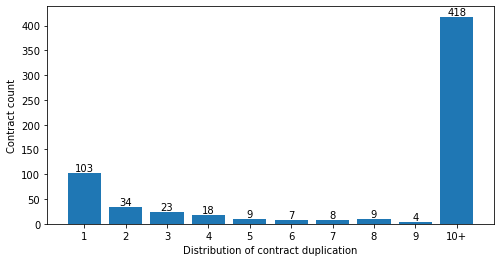

In [2]:
def count_reuse(new_df,num):
    return len(new_df[new_df['reusetime'] == num])
def count_out_reuse(new_df,num):
    return len(new_df[new_df['reusetime'] >= num])
num_count = []
for i in range(1,10):
    num_count.append(count_reuse(new_df,i))
num_count.append(count_out_reuse(new_df,10))
num_count
def barr(keys,values):
    fig = plt.figure(figsize=(8,4))
    plt.bar(keys, values)
    for a,b in zip(keys,values):
        plt.text(a, b+0.01, '%.0f' % b, ha='center', va= 'bottom')
    plt.xticks()
    plt.xlabel("Distribution of contract duplication")
    plt.ylabel("Contract count")
    plt.show()
num_count = [103,34,23,18,9,7,8,9,4,418]
barr(['1','2','3','4','5','6','7','8','9','10+'],num_count)

In [25]:
#检查
addr = new_df['address']
addr = addr.drop_duplicates()
error = 0
for address in list(addr):
    #print(address)
    if address not in list(bb['code_name']):
        error += 1
print(error)
print(len(addr))

184
566


In [22]:
code_addr = bb['code_name']
code_addr = code_addr.drop_duplicates()
len(code_addr)

419